In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision

from torch.utils.tensorboard import SummaryWriter

import numpy as np
import os
import random
from tqdm import tqdm
import matplotlib.pyplot as plt

from medsegbench import UltrasoundNerveMSBench
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score

from torch.utils.data import Dataset
import torchvision.transforms as transforms


In [16]:
# For reproducibility
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(42)

In [17]:
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
print("Name of device:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

Using device: cuda
Name of device: NVIDIA GeForce RTX 4060 Laptop GPU


In [18]:
# Transforms
transform = transforms.Compose([
    transforms.ToTensor()
])

# Dataset loading (256x256 as required)
train_dataset = UltrasoundNerveMSBench(split='train', size=256, transform=transform, target_transform=transform, download=True)
val_dataset = UltrasoundNerveMSBench(split='val', size=256, transform=transform, target_transform=transform, download=True)
test_dataset = UltrasoundNerveMSBench(split='test', size=256, transform=transform, target_transform=transform, download=True)

batchsize = 8

train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batchsize, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False)

# Print dataset details for verification
print(f"Train samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(val_loader.dataset)}")
print(f"Test samples: {len(test_loader.dataset)}")

print(f"Image size: {train_dataset[0][0].shape}")
print(f"Label size: {train_dataset[0][1].shape}")

Train samples: 1651
Validation samples: 223
Test samples: 449
Image size: torch.Size([1, 256, 256])
Label size: torch.Size([1, 256, 256])


In [19]:
import torch
import torch.nn as nn

class ResNet18Block(nn.Module):
    expansion = 1
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, stride, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        if self.downsample is not None:
            identity = self.downsample(x)
        out += identity
        out = self.relu(out)
        return out

class DecoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.block(x)

class UNetResNet18(nn.Module):
    def __init__(self, output_channels=1):
        super().__init__()
        # Encoder
        self.initial_conv = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.initial_bn = nn.BatchNorm2d(64)
        self.initial_relu = nn.ReLU(inplace=True)
        self.initial_pool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.encoder_stage1 = self._make_encoder_layer(64, 64, num_blocks=2, stride=1)
        self.encoder_stage2 = self._make_encoder_layer(64, 128, num_blocks=2, stride=2)
        self.encoder_stage3 = self._make_encoder_layer(128, 256, num_blocks=2, stride=2)
        self.encoder_stage4 = self._make_encoder_layer(256, 512, num_blocks=2, stride=2)

        # Decoder
        self.upconv4 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.decoder_stage4 = DecoderBlock(256+256, 256)
        self.upconv3 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.decoder_stage3 = DecoderBlock(128+128, 128)
        self.upconv2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.decoder_stage2 = DecoderBlock(64+64, 64)
        self.upconv1 = nn.ConvTranspose2d(64, 64, 2, stride=2)
        self.decoder_stage1 = DecoderBlock(64+64, 64)

        self.output_conv = nn.Conv2d(64, output_channels, kernel_size=1)

    def _make_encoder_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = [ResNet18Block(in_channels, out_channels, stride)]
        for _ in range(1, num_blocks):
            layers.append(ResNet18Block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        # Encoder
        x0 = self.initial_relu(self.initial_bn(self.initial_conv(x)))  # 64, 128x128
        x1 = self.initial_pool(x0)                                    # 64, 64x64
        x2 = self.encoder_stage1(x1)                                  # 64, 64x64
        x3 = self.encoder_stage2(x2)                                  # 128, 32x32
        x4 = self.encoder_stage3(x3)                                  # 256, 16x16
        x5 = self.encoder_stage4(x4)                                  # 512, 8x8

        # Decoder
        d4 = self.upconv4(x5)                                         # 256, 16x16
        d4 = self._concat_and_resize(d4, x4)
        d4 = self.decoder_stage4(d4)

        d3 = self.upconv3(d4)                                         # 128, 32x32
        d3 = self._concat_and_resize(d3, x3)
        d3 = self.decoder_stage3(d3)

        d2 = self.upconv2(d3)                                         # 64, 64x64
        d2 = self._concat_and_resize(d2, x2)
        d2 = self.decoder_stage2(d2)

        d1 = self.upconv1(d2)                                         # 64, 128x128
        d1 = self._concat_and_resize(d1, x0)
        d1 = self.decoder_stage1(d1)

        output = nn.functional.interpolate(d1, scale_factor=2, mode="bilinear", align_corners=False)  # 64, 256x256
        output = self.output_conv(output)                            # output_channels, 256x256
        return output

    def _concat_and_resize(self, upsampled, encoder_feature):
        if upsampled.shape[-2:] != encoder_feature.shape[-2:]:
            upsampled = nn.functional.interpolate(upsampled, size=encoder_feature.shape[-2:], mode="bilinear", align_corners=False)
        return torch.cat([upsampled, encoder_feature], dim=1)

# Kullanım örneği:
# model = UNetResNet18(output_channels=1)
# x = torch.randn(1, 3, 256, 256)
# y = model(x)
# print(y.shape)  # (1, 1, 256, 256)

In [20]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, logits, targets):
        # If logits are not probabilities, apply sigmoid
        probs = torch.sigmoid(logits)
        targets = targets.float()

        intersection = (probs * targets).sum(dim=(1,2))
        union = probs.sum(dim=(1,2)) + targets.sum(dim=(1,2))
        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice.mean()

In [21]:
""" class BCEDiceLoss(nn.Module):
    def __init__(self, smooth=1e-5):
        super().__init__()
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss(smooth=smooth)
    def forward(self, logits, targets):
        return self.bce(logits, targets) + self.dice(logits, targets) """

' class BCEDiceLoss(nn.Module):\n    def __init__(self, smooth=1e-5):\n        super().__init__()\n        self.bce = nn.BCEWithLogitsLoss()\n        self.dice = DiceLoss(smooth=smooth)\n    def forward(self, logits, targets):\n        return self.bce(logits, targets) + self.dice(logits, targets) '

In [22]:
# --- Hyperparameters ---
num_epochs = 150
batch_size = 8    # should match your loader
learning_rate = 1e-4
log_dir = "runs/150epochDicelossexperiment2"
model_save_path = "best_model.pth"

# --- Model, Loss, Optimizer ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetResNet18().to(device)
criterion = DiceLoss()  # for binary segmentation
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [23]:
# --- TensorBoard Writer ---
writer = SummaryWriter(log_dir=log_dir)

def to_3channel(img_tensor):
    """Repeat single channel to 3 channels for ResNet18 input."""
    if img_tensor.shape[1] == 1:
        return img_tensor.repeat(1, 3, 1, 1)
    return img_tensor

def sigmoid_output(outputs):
    return torch.sigmoid(outputs)

def calc_accuracy(outputs, labels, threshold=0.5):
    preds = sigmoid_output(outputs) > threshold
    correct = (preds == labels).float()
    return correct.sum() / torch.numel(correct)


In [24]:
# --- Training and Validation Loop ---
best_val_loss = float("inf")

for epoch in range(num_epochs):
    # --- Training ---
    model.train()
    train_loss = 0.0
    train_acc = 0.0
    for images, masks in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
        images = to_3channel(images).to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        outputs = outputs.squeeze(1)  # [B, H, W]
        masks = masks.squeeze(1)      # [B, H, W]
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        train_acc += calc_accuracy(outputs, masks) * images.size(0)
    train_loss /= len(train_loader.dataset)
    train_acc /= len(train_loader.dataset)

    # --- Validation ---
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    with torch.no_grad():
        for i, (images, masks) in enumerate(val_loader):
            images = to_3channel(images).to(device)
            masks = masks.to(device)
            outputs = model(images)
            outputs = outputs.squeeze(1)
            masks = masks.squeeze(1)
            loss = criterion(outputs, masks)
            val_loss += loss.item() * images.size(0)
            val_acc += calc_accuracy(outputs, masks) * images.size(0)
            # Log images to TensorBoard (only for first batch of each epoch)
            if i == 0:
                grid_input = torchvision.utils.make_grid(images[:, 0:1], normalize=True)
                grid_pred = torchvision.utils.make_grid((sigmoid_output(outputs) > 0.5).float().unsqueeze(1), normalize=True)
                grid_target = torchvision.utils.make_grid(masks.unsqueeze(1), normalize=True)
                writer.add_image('val/input_image', grid_input, epoch)
                writer.add_image('val/predicted_segmented_image', grid_pred, epoch)
                writer.add_image('val/target_image', grid_target, epoch)
    val_loss /= len(val_loader.dataset)
    val_acc /= len(val_loader.dataset)

    # --- TensorBoard Logging ---
    writer.add_scalar("Loss/train", train_loss, epoch)
    writer.add_scalar("Loss/val", val_loss, epoch)
    writer.add_scalar("Accuracy/train", train_acc, epoch)
    writer.add_scalar("Accuracy/val", val_acc, epoch)

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    # --- Save Best Model ---
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), model_save_path)
        best_val_loss = val_loss
        print(f"Best model saved at epoch {epoch+1} with validation loss: {val_loss:.4f}")

writer.close()
print("Training complete. Best model saved to:", model_save_path)

Epoch 1/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.67it/s]


Epoch 1/150 | Train Loss: 0.8413 | Val Loss: 0.8082 | Train Acc: 0.8753 | Val Acc: 0.9496
Best model saved at epoch 1 with validation loss: 0.8082


Epoch 2/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.77it/s]


Epoch 2/150 | Train Loss: 0.7561 | Val Loss: 0.7117 | Train Acc: 0.9677 | Val Acc: 0.9686
Best model saved at epoch 2 with validation loss: 0.7117


Epoch 3/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.77it/s]


Epoch 3/150 | Train Loss: 0.6581 | Val Loss: 0.6068 | Train Acc: 0.9782 | Val Acc: 0.9832
Best model saved at epoch 3 with validation loss: 0.6068


Epoch 4/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.74it/s]


Epoch 4/150 | Train Loss: 0.5158 | Val Loss: 0.4693 | Train Acc: 0.9837 | Val Acc: 0.9843
Best model saved at epoch 4 with validation loss: 0.4693


Epoch 5/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.64it/s]


Epoch 5/150 | Train Loss: 0.3962 | Val Loss: 0.3801 | Train Acc: 0.9872 | Val Acc: 0.9830
Best model saved at epoch 5 with validation loss: 0.3801


Epoch 6/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.46it/s]


Epoch 6/150 | Train Loss: 0.3099 | Val Loss: 0.3218 | Train Acc: 0.9891 | Val Acc: 0.9873
Best model saved at epoch 6 with validation loss: 0.3218


Epoch 7/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.25it/s]


Epoch 7/150 | Train Loss: 0.2578 | Val Loss: 0.2855 | Train Acc: 0.9899 | Val Acc: 0.9884
Best model saved at epoch 7 with validation loss: 0.2855


Epoch 8/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.10it/s]


Epoch 8/150 | Train Loss: 0.2224 | Val Loss: 0.2645 | Train Acc: 0.9905 | Val Acc: 0.9880
Best model saved at epoch 8 with validation loss: 0.2645


Epoch 9/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.27it/s]


Epoch 9/150 | Train Loss: 0.1966 | Val Loss: 0.2438 | Train Acc: 0.9911 | Val Acc: 0.9872
Best model saved at epoch 9 with validation loss: 0.2438


Epoch 10/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.34it/s]


Epoch 10/150 | Train Loss: 0.1795 | Val Loss: 0.2424 | Train Acc: 0.9915 | Val Acc: 0.9869
Best model saved at epoch 10 with validation loss: 0.2424


Epoch 11/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.37it/s]


Epoch 11/150 | Train Loss: 0.1637 | Val Loss: 0.2323 | Train Acc: 0.9920 | Val Acc: 0.9877
Best model saved at epoch 11 with validation loss: 0.2323


Epoch 12/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.29it/s]


Epoch 12/150 | Train Loss: 0.1531 | Val Loss: 0.2410 | Train Acc: 0.9923 | Val Acc: 0.9850


Epoch 13/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.24it/s]


Epoch 13/150 | Train Loss: 0.1444 | Val Loss: 0.2154 | Train Acc: 0.9926 | Val Acc: 0.9880
Best model saved at epoch 13 with validation loss: 0.2154


Epoch 14/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.20it/s]


Epoch 14/150 | Train Loss: 0.1341 | Val Loss: 0.2287 | Train Acc: 0.9930 | Val Acc: 0.9883


Epoch 15/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 14.90it/s]


Epoch 15/150 | Train Loss: 0.1272 | Val Loss: 0.2180 | Train Acc: 0.9933 | Val Acc: 0.9881


Epoch 16/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.06it/s]


Epoch 16/150 | Train Loss: 0.1228 | Val Loss: 0.2207 | Train Acc: 0.9934 | Val Acc: 0.9882


Epoch 17/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.12it/s]


Epoch 17/150 | Train Loss: 0.1162 | Val Loss: 0.2155 | Train Acc: 0.9937 | Val Acc: 0.9882


Epoch 18/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 14.92it/s]


Epoch 18/150 | Train Loss: 0.1102 | Val Loss: 0.2100 | Train Acc: 0.9940 | Val Acc: 0.9884
Best model saved at epoch 18 with validation loss: 0.2100


Epoch 19/150 [Train]: 100%|██████████| 207/207 [00:14<00:00, 14.73it/s]


Epoch 19/150 | Train Loss: 0.1071 | Val Loss: 0.2112 | Train Acc: 0.9941 | Val Acc: 0.9878


Epoch 20/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 14.79it/s]


Epoch 20/150 | Train Loss: 0.1008 | Val Loss: 0.2123 | Train Acc: 0.9944 | Val Acc: 0.9880


Epoch 21/150 [Train]: 100%|██████████| 207/207 [00:14<00:00, 14.63it/s]


Epoch 21/150 | Train Loss: 0.0967 | Val Loss: 0.2123 | Train Acc: 0.9946 | Val Acc: 0.9880


Epoch 22/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 14.85it/s]


Epoch 22/150 | Train Loss: 0.0946 | Val Loss: 0.2192 | Train Acc: 0.9947 | Val Acc: 0.9880


Epoch 23/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.07it/s]


Epoch 23/150 | Train Loss: 0.0912 | Val Loss: 0.2182 | Train Acc: 0.9949 | Val Acc: 0.9881


Epoch 24/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.18it/s]


Epoch 24/150 | Train Loss: 0.0870 | Val Loss: 0.2212 | Train Acc: 0.9951 | Val Acc: 0.9878


Epoch 25/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.16it/s]


Epoch 25/150 | Train Loss: 0.0842 | Val Loss: 0.2196 | Train Acc: 0.9952 | Val Acc: 0.9881


Epoch 26/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.17it/s]


Epoch 26/150 | Train Loss: 0.0827 | Val Loss: 0.2212 | Train Acc: 0.9953 | Val Acc: 0.9880


Epoch 27/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.15it/s]


Epoch 27/150 | Train Loss: 0.0843 | Val Loss: 0.2259 | Train Acc: 0.9952 | Val Acc: 0.9878


Epoch 28/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.15it/s]


Epoch 28/150 | Train Loss: 0.0817 | Val Loss: 0.2124 | Train Acc: 0.9953 | Val Acc: 0.9880


Epoch 29/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.33it/s]


Epoch 29/150 | Train Loss: 0.0767 | Val Loss: 0.2187 | Train Acc: 0.9956 | Val Acc: 0.9881


Epoch 30/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.14it/s]


Epoch 30/150 | Train Loss: 0.0741 | Val Loss: 0.2134 | Train Acc: 0.9957 | Val Acc: 0.9880


Epoch 31/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.04it/s]


Epoch 31/150 | Train Loss: 0.0723 | Val Loss: 0.2174 | Train Acc: 0.9958 | Val Acc: 0.9880


Epoch 32/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 14.96it/s]


Epoch 32/150 | Train Loss: 0.0705 | Val Loss: 0.2233 | Train Acc: 0.9959 | Val Acc: 0.9878


Epoch 33/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.26it/s]


Epoch 33/150 | Train Loss: 0.0698 | Val Loss: 0.2227 | Train Acc: 0.9960 | Val Acc: 0.9879


Epoch 34/150 [Train]: 100%|██████████| 207/207 [00:14<00:00, 14.41it/s]


Epoch 34/150 | Train Loss: 0.0697 | Val Loss: 0.2239 | Train Acc: 0.9960 | Val Acc: 0.9878


Epoch 35/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.05it/s]


Epoch 35/150 | Train Loss: 0.0691 | Val Loss: 0.2157 | Train Acc: 0.9960 | Val Acc: 0.9881


Epoch 36/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.06it/s]


Epoch 36/150 | Train Loss: 0.0664 | Val Loss: 0.2120 | Train Acc: 0.9961 | Val Acc: 0.9878


Epoch 37/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.30it/s]


Epoch 37/150 | Train Loss: 0.0658 | Val Loss: 0.2148 | Train Acc: 0.9962 | Val Acc: 0.9876


Epoch 38/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 14.97it/s]


Epoch 38/150 | Train Loss: 0.0632 | Val Loss: 0.2153 | Train Acc: 0.9963 | Val Acc: 0.9878


Epoch 39/150 [Train]: 100%|██████████| 207/207 [00:14<00:00, 14.64it/s]


Epoch 39/150 | Train Loss: 0.0618 | Val Loss: 0.2214 | Train Acc: 0.9964 | Val Acc: 0.9878


Epoch 40/150 [Train]: 100%|██████████| 207/207 [00:14<00:00, 14.66it/s]


Epoch 40/150 | Train Loss: 0.0615 | Val Loss: 0.2219 | Train Acc: 0.9964 | Val Acc: 0.9878


Epoch 41/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.19it/s]


Epoch 41/150 | Train Loss: 0.0615 | Val Loss: 0.2174 | Train Acc: 0.9964 | Val Acc: 0.9878


Epoch 42/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 14.86it/s]


Epoch 42/150 | Train Loss: 0.0603 | Val Loss: 0.2224 | Train Acc: 0.9965 | Val Acc: 0.9878


Epoch 43/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 14.99it/s]


Epoch 43/150 | Train Loss: 0.0592 | Val Loss: 0.2179 | Train Acc: 0.9965 | Val Acc: 0.9877


Epoch 44/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 14.95it/s]


Epoch 44/150 | Train Loss: 0.0594 | Val Loss: 0.2199 | Train Acc: 0.9965 | Val Acc: 0.9876


Epoch 45/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.06it/s]


Epoch 45/150 | Train Loss: 0.0576 | Val Loss: 0.2239 | Train Acc: 0.9966 | Val Acc: 0.9876


Epoch 46/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.15it/s]


Epoch 46/150 | Train Loss: 0.0573 | Val Loss: 0.2271 | Train Acc: 0.9966 | Val Acc: 0.9878


Epoch 47/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.15it/s]


Epoch 47/150 | Train Loss: 0.0556 | Val Loss: 0.2226 | Train Acc: 0.9967 | Val Acc: 0.9877


Epoch 48/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 14.82it/s]


Epoch 48/150 | Train Loss: 0.0547 | Val Loss: 0.2184 | Train Acc: 0.9968 | Val Acc: 0.9877


Epoch 49/150 [Train]: 100%|██████████| 207/207 [00:14<00:00, 14.53it/s]


Epoch 49/150 | Train Loss: 0.0543 | Val Loss: 0.2181 | Train Acc: 0.9968 | Val Acc: 0.9877


Epoch 50/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.18it/s]


Epoch 50/150 | Train Loss: 0.0538 | Val Loss: 0.2315 | Train Acc: 0.9968 | Val Acc: 0.9877


Epoch 51/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.23it/s]


Epoch 51/150 | Train Loss: 0.0540 | Val Loss: 0.2240 | Train Acc: 0.9968 | Val Acc: 0.9877


Epoch 52/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.30it/s]


Epoch 52/150 | Train Loss: 0.0539 | Val Loss: 0.2289 | Train Acc: 0.9968 | Val Acc: 0.9877


Epoch 53/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.36it/s]


Epoch 53/150 | Train Loss: 0.0531 | Val Loss: 0.2263 | Train Acc: 0.9969 | Val Acc: 0.9877


Epoch 54/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.25it/s]


Epoch 54/150 | Train Loss: 0.0529 | Val Loss: 0.2236 | Train Acc: 0.9969 | Val Acc: 0.9875


Epoch 55/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.24it/s]


Epoch 55/150 | Train Loss: 0.0519 | Val Loss: 0.2213 | Train Acc: 0.9969 | Val Acc: 0.9876


Epoch 56/150 [Train]: 100%|██████████| 207/207 [00:14<00:00, 14.77it/s]


Epoch 56/150 | Train Loss: 0.0522 | Val Loss: 0.2217 | Train Acc: 0.9969 | Val Acc: 0.9874


Epoch 57/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.00it/s]


Epoch 57/150 | Train Loss: 0.0517 | Val Loss: 0.2161 | Train Acc: 0.9969 | Val Acc: 0.9876


Epoch 58/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.21it/s]


Epoch 58/150 | Train Loss: 0.0503 | Val Loss: 0.2211 | Train Acc: 0.9970 | Val Acc: 0.9878


Epoch 59/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.25it/s]


Epoch 59/150 | Train Loss: 0.0498 | Val Loss: 0.2205 | Train Acc: 0.9970 | Val Acc: 0.9878


Epoch 60/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.42it/s]


Epoch 60/150 | Train Loss: 0.0485 | Val Loss: 0.2269 | Train Acc: 0.9971 | Val Acc: 0.9876


Epoch 61/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.33it/s]


Epoch 61/150 | Train Loss: 0.0494 | Val Loss: 0.2253 | Train Acc: 0.9971 | Val Acc: 0.9877


Epoch 62/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.34it/s]


Epoch 62/150 | Train Loss: 0.0478 | Val Loss: 0.2179 | Train Acc: 0.9972 | Val Acc: 0.9876


Epoch 63/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.24it/s]


Epoch 63/150 | Train Loss: 0.0482 | Val Loss: 0.2255 | Train Acc: 0.9971 | Val Acc: 0.9874


Epoch 64/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.31it/s]


Epoch 64/150 | Train Loss: 0.0469 | Val Loss: 0.2209 | Train Acc: 0.9972 | Val Acc: 0.9877


Epoch 65/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.34it/s]


Epoch 65/150 | Train Loss: 0.0480 | Val Loss: 0.2337 | Train Acc: 0.9972 | Val Acc: 0.9876


Epoch 66/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.30it/s]


Epoch 66/150 | Train Loss: 0.0472 | Val Loss: 0.2213 | Train Acc: 0.9972 | Val Acc: 0.9877


Epoch 67/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.29it/s]


Epoch 67/150 | Train Loss: 0.0466 | Val Loss: 0.2182 | Train Acc: 0.9972 | Val Acc: 0.9877


Epoch 68/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.38it/s]


Epoch 68/150 | Train Loss: 0.0463 | Val Loss: 0.2260 | Train Acc: 0.9972 | Val Acc: 0.9876


Epoch 69/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.31it/s]


Epoch 69/150 | Train Loss: 0.0460 | Val Loss: 0.2256 | Train Acc: 0.9973 | Val Acc: 0.9874


Epoch 70/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.34it/s]


Epoch 70/150 | Train Loss: 0.0464 | Val Loss: 0.2283 | Train Acc: 0.9972 | Val Acc: 0.9874


Epoch 71/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.34it/s]


Epoch 71/150 | Train Loss: 0.0461 | Val Loss: 0.2272 | Train Acc: 0.9973 | Val Acc: 0.9873


Epoch 72/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.11it/s]


Epoch 72/150 | Train Loss: 0.0471 | Val Loss: 0.2317 | Train Acc: 0.9972 | Val Acc: 0.9876


Epoch 73/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.39it/s]


Epoch 73/150 | Train Loss: 0.0451 | Val Loss: 0.2271 | Train Acc: 0.9973 | Val Acc: 0.9877


Epoch 74/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.04it/s]


Epoch 74/150 | Train Loss: 0.0436 | Val Loss: 0.2234 | Train Acc: 0.9974 | Val Acc: 0.9875


Epoch 75/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 14.90it/s]


Epoch 75/150 | Train Loss: 0.0453 | Val Loss: 0.2267 | Train Acc: 0.9973 | Val Acc: 0.9876


Epoch 76/150 [Train]: 100%|██████████| 207/207 [00:14<00:00, 14.61it/s]


Epoch 76/150 | Train Loss: 0.0443 | Val Loss: 0.2282 | Train Acc: 0.9974 | Val Acc: 0.9878


Epoch 77/150 [Train]: 100%|██████████| 207/207 [00:14<00:00, 14.11it/s]


Epoch 77/150 | Train Loss: 0.0431 | Val Loss: 0.2282 | Train Acc: 0.9974 | Val Acc: 0.9876


Epoch 78/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.11it/s]


Epoch 78/150 | Train Loss: 0.0433 | Val Loss: 0.2213 | Train Acc: 0.9974 | Val Acc: 0.9874


Epoch 79/150 [Train]: 100%|██████████| 207/207 [00:14<00:00, 14.72it/s]


Epoch 79/150 | Train Loss: 0.0425 | Val Loss: 0.2291 | Train Acc: 0.9975 | Val Acc: 0.9878


Epoch 80/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 14.92it/s]


Epoch 80/150 | Train Loss: 0.0426 | Val Loss: 0.2280 | Train Acc: 0.9975 | Val Acc: 0.9877


Epoch 81/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.02it/s]


Epoch 81/150 | Train Loss: 0.0422 | Val Loss: 0.2237 | Train Acc: 0.9975 | Val Acc: 0.9878


Epoch 82/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.10it/s]


Epoch 82/150 | Train Loss: 0.0419 | Val Loss: 0.2252 | Train Acc: 0.9975 | Val Acc: 0.9876


Epoch 83/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 14.81it/s]


Epoch 83/150 | Train Loss: 0.0416 | Val Loss: 0.2255 | Train Acc: 0.9975 | Val Acc: 0.9877


Epoch 84/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 14.88it/s]


Epoch 84/150 | Train Loss: 0.0407 | Val Loss: 0.2255 | Train Acc: 0.9976 | Val Acc: 0.9876


Epoch 85/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.14it/s]


Epoch 85/150 | Train Loss: 0.0412 | Val Loss: 0.2234 | Train Acc: 0.9975 | Val Acc: 0.9876


Epoch 86/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.16it/s]


Epoch 86/150 | Train Loss: 0.0424 | Val Loss: 0.2287 | Train Acc: 0.9975 | Val Acc: 0.9876


Epoch 87/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 14.93it/s]


Epoch 87/150 | Train Loss: 0.0453 | Val Loss: 0.2269 | Train Acc: 0.9973 | Val Acc: 0.9876


Epoch 88/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 14.85it/s]


Epoch 88/150 | Train Loss: 0.0418 | Val Loss: 0.2350 | Train Acc: 0.9975 | Val Acc: 0.9875


Epoch 89/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 14.93it/s]


Epoch 89/150 | Train Loss: 0.0406 | Val Loss: 0.2293 | Train Acc: 0.9976 | Val Acc: 0.9877


Epoch 90/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 14.79it/s]


Epoch 90/150 | Train Loss: 0.0407 | Val Loss: 0.2261 | Train Acc: 0.9976 | Val Acc: 0.9875


Epoch 91/150 [Train]: 100%|██████████| 207/207 [00:14<00:00, 14.19it/s]


Epoch 91/150 | Train Loss: 0.0401 | Val Loss: 0.2278 | Train Acc: 0.9976 | Val Acc: 0.9877


Epoch 92/150 [Train]: 100%|██████████| 207/207 [00:14<00:00, 14.67it/s]


Epoch 92/150 | Train Loss: 0.0397 | Val Loss: 0.2294 | Train Acc: 0.9976 | Val Acc: 0.9877


Epoch 93/150 [Train]: 100%|██████████| 207/207 [00:14<00:00, 14.64it/s]


Epoch 93/150 | Train Loss: 0.0397 | Val Loss: 0.2262 | Train Acc: 0.9976 | Val Acc: 0.9878


Epoch 94/150 [Train]: 100%|██████████| 207/207 [00:14<00:00, 14.70it/s]


Epoch 94/150 | Train Loss: 0.0405 | Val Loss: 0.2286 | Train Acc: 0.9976 | Val Acc: 0.9876


Epoch 95/150 [Train]: 100%|██████████| 207/207 [00:14<00:00, 14.56it/s]


Epoch 95/150 | Train Loss: 0.0391 | Val Loss: 0.2308 | Train Acc: 0.9977 | Val Acc: 0.9876


Epoch 96/150 [Train]: 100%|██████████| 207/207 [00:14<00:00, 14.66it/s]


Epoch 96/150 | Train Loss: 0.0383 | Val Loss: 0.2331 | Train Acc: 0.9977 | Val Acc: 0.9877


Epoch 97/150 [Train]: 100%|██████████| 207/207 [00:14<00:00, 14.66it/s]


Epoch 97/150 | Train Loss: 0.0393 | Val Loss: 0.2306 | Train Acc: 0.9976 | Val Acc: 0.9877


Epoch 98/150 [Train]: 100%|██████████| 207/207 [00:14<00:00, 14.71it/s]


Epoch 98/150 | Train Loss: 0.0385 | Val Loss: 0.2314 | Train Acc: 0.9977 | Val Acc: 0.9879


Epoch 99/150 [Train]: 100%|██████████| 207/207 [00:14<00:00, 14.74it/s]


Epoch 99/150 | Train Loss: 0.0379 | Val Loss: 0.2276 | Train Acc: 0.9977 | Val Acc: 0.9878


Epoch 100/150 [Train]: 100%|██████████| 207/207 [00:14<00:00, 14.68it/s]


Epoch 100/150 | Train Loss: 0.0376 | Val Loss: 0.2270 | Train Acc: 0.9978 | Val Acc: 0.9877


Epoch 101/150 [Train]: 100%|██████████| 207/207 [00:14<00:00, 14.69it/s]


Epoch 101/150 | Train Loss: 0.0385 | Val Loss: 0.2288 | Train Acc: 0.9977 | Val Acc: 0.9876


Epoch 102/150 [Train]: 100%|██████████| 207/207 [00:14<00:00, 14.70it/s]


Epoch 102/150 | Train Loss: 0.0380 | Val Loss: 0.2275 | Train Acc: 0.9977 | Val Acc: 0.9876


Epoch 103/150 [Train]: 100%|██████████| 207/207 [00:14<00:00, 14.77it/s]


Epoch 103/150 | Train Loss: 0.0378 | Val Loss: 0.2321 | Train Acc: 0.9977 | Val Acc: 0.9875


Epoch 104/150 [Train]: 100%|██████████| 207/207 [00:14<00:00, 14.75it/s]


Epoch 104/150 | Train Loss: 0.0376 | Val Loss: 0.2324 | Train Acc: 0.9977 | Val Acc: 0.9875


Epoch 105/150 [Train]: 100%|██████████| 207/207 [00:14<00:00, 14.70it/s]


Epoch 105/150 | Train Loss: 0.0378 | Val Loss: 0.2276 | Train Acc: 0.9977 | Val Acc: 0.9876


Epoch 106/150 [Train]: 100%|██████████| 207/207 [00:14<00:00, 14.74it/s]


Epoch 106/150 | Train Loss: 0.0378 | Val Loss: 0.2252 | Train Acc: 0.9977 | Val Acc: 0.9877


Epoch 107/150 [Train]: 100%|██████████| 207/207 [00:14<00:00, 14.78it/s]


Epoch 107/150 | Train Loss: 0.0381 | Val Loss: 0.2282 | Train Acc: 0.9977 | Val Acc: 0.9875


Epoch 108/150 [Train]: 100%|██████████| 207/207 [00:14<00:00, 14.72it/s]


Epoch 108/150 | Train Loss: 0.0369 | Val Loss: 0.2325 | Train Acc: 0.9978 | Val Acc: 0.9877


Epoch 109/150 [Train]: 100%|██████████| 207/207 [00:14<00:00, 14.75it/s]


Epoch 109/150 | Train Loss: 0.0361 | Val Loss: 0.2310 | Train Acc: 0.9978 | Val Acc: 0.9877


Epoch 110/150 [Train]: 100%|██████████| 207/207 [00:14<00:00, 14.61it/s]


Epoch 110/150 | Train Loss: 0.0357 | Val Loss: 0.2305 | Train Acc: 0.9979 | Val Acc: 0.9877


Epoch 111/150 [Train]: 100%|██████████| 207/207 [00:14<00:00, 14.66it/s]


Epoch 111/150 | Train Loss: 0.0356 | Val Loss: 0.2267 | Train Acc: 0.9979 | Val Acc: 0.9877


Epoch 112/150 [Train]: 100%|██████████| 207/207 [00:15<00:00, 13.77it/s]


Epoch 112/150 | Train Loss: 0.0355 | Val Loss: 0.2268 | Train Acc: 0.9979 | Val Acc: 0.9878


Epoch 113/150 [Train]: 100%|██████████| 207/207 [00:14<00:00, 14.05it/s]


Epoch 113/150 | Train Loss: 0.0349 | Val Loss: 0.2301 | Train Acc: 0.9979 | Val Acc: 0.9877


Epoch 114/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 14.95it/s]


Epoch 114/150 | Train Loss: 0.0353 | Val Loss: 0.2312 | Train Acc: 0.9979 | Val Acc: 0.9877


Epoch 115/150 [Train]: 100%|██████████| 207/207 [00:14<00:00, 14.02it/s]


Epoch 115/150 | Train Loss: 0.0349 | Val Loss: 0.2278 | Train Acc: 0.9979 | Val Acc: 0.9876


Epoch 116/150 [Train]: 100%|██████████| 207/207 [00:14<00:00, 14.75it/s]


Epoch 116/150 | Train Loss: 0.0349 | Val Loss: 0.2352 | Train Acc: 0.9979 | Val Acc: 0.9875


Epoch 117/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.02it/s]


Epoch 117/150 | Train Loss: 0.0352 | Val Loss: 0.2343 | Train Acc: 0.9979 | Val Acc: 0.9879


Epoch 118/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.13it/s]


Epoch 118/150 | Train Loss: 0.0356 | Val Loss: 0.2277 | Train Acc: 0.9979 | Val Acc: 0.9876


Epoch 119/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 14.85it/s]


Epoch 119/150 | Train Loss: 0.0348 | Val Loss: 0.2292 | Train Acc: 0.9979 | Val Acc: 0.9876


Epoch 120/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.00it/s]


Epoch 120/150 | Train Loss: 0.0341 | Val Loss: 0.2392 | Train Acc: 0.9979 | Val Acc: 0.9875


Epoch 121/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 14.93it/s]


Epoch 121/150 | Train Loss: 0.0339 | Val Loss: 0.2307 | Train Acc: 0.9980 | Val Acc: 0.9877


Epoch 122/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.11it/s]


Epoch 122/150 | Train Loss: 0.0345 | Val Loss: 0.2317 | Train Acc: 0.9979 | Val Acc: 0.9877


Epoch 123/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.09it/s]


Epoch 123/150 | Train Loss: 0.0358 | Val Loss: 0.2355 | Train Acc: 0.9978 | Val Acc: 0.9876


Epoch 124/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.13it/s]


Epoch 124/150 | Train Loss: 0.0347 | Val Loss: 0.2232 | Train Acc: 0.9979 | Val Acc: 0.9876


Epoch 125/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.16it/s]


Epoch 125/150 | Train Loss: 0.0340 | Val Loss: 0.2304 | Train Acc: 0.9979 | Val Acc: 0.9877


Epoch 126/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.16it/s]


Epoch 126/150 | Train Loss: 0.0333 | Val Loss: 0.2273 | Train Acc: 0.9980 | Val Acc: 0.9878


Epoch 127/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.18it/s]


Epoch 127/150 | Train Loss: 0.0331 | Val Loss: 0.2310 | Train Acc: 0.9980 | Val Acc: 0.9878


Epoch 128/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.10it/s]


Epoch 128/150 | Train Loss: 0.0330 | Val Loss: 0.2336 | Train Acc: 0.9980 | Val Acc: 0.9877


Epoch 129/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.13it/s]


Epoch 129/150 | Train Loss: 0.0332 | Val Loss: 0.2347 | Train Acc: 0.9980 | Val Acc: 0.9877


Epoch 130/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.18it/s]


Epoch 130/150 | Train Loss: 0.0335 | Val Loss: 0.2347 | Train Acc: 0.9980 | Val Acc: 0.9877


Epoch 131/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 14.93it/s]


Epoch 131/150 | Train Loss: 0.0336 | Val Loss: 0.2264 | Train Acc: 0.9980 | Val Acc: 0.9878


Epoch 132/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.03it/s]


Epoch 132/150 | Train Loss: 0.0330 | Val Loss: 0.2257 | Train Acc: 0.9980 | Val Acc: 0.9877


Epoch 133/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.42it/s]


Epoch 133/150 | Train Loss: 0.0327 | Val Loss: 0.2303 | Train Acc: 0.9980 | Val Acc: 0.9878


Epoch 134/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.21it/s]


Epoch 134/150 | Train Loss: 0.0328 | Val Loss: 0.2301 | Train Acc: 0.9980 | Val Acc: 0.9879


Epoch 135/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.32it/s]


Epoch 135/150 | Train Loss: 0.0330 | Val Loss: 0.2359 | Train Acc: 0.9980 | Val Acc: 0.9875


Epoch 136/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.30it/s]


Epoch 136/150 | Train Loss: 0.0325 | Val Loss: 0.2303 | Train Acc: 0.9980 | Val Acc: 0.9879


Epoch 137/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.32it/s]


Epoch 137/150 | Train Loss: 0.0322 | Val Loss: 0.2285 | Train Acc: 0.9981 | Val Acc: 0.9876


Epoch 138/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.32it/s]


Epoch 138/150 | Train Loss: 0.0325 | Val Loss: 0.2297 | Train Acc: 0.9980 | Val Acc: 0.9877


Epoch 139/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.32it/s]


Epoch 139/150 | Train Loss: 0.0324 | Val Loss: 0.2296 | Train Acc: 0.9980 | Val Acc: 0.9878


Epoch 140/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.18it/s]


Epoch 140/150 | Train Loss: 0.0321 | Val Loss: 0.2307 | Train Acc: 0.9981 | Val Acc: 0.9878


Epoch 141/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.25it/s]


Epoch 141/150 | Train Loss: 0.0319 | Val Loss: 0.2274 | Train Acc: 0.9981 | Val Acc: 0.9877


Epoch 142/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.29it/s]


Epoch 142/150 | Train Loss: 0.0313 | Val Loss: 0.2271 | Train Acc: 0.9981 | Val Acc: 0.9879


Epoch 143/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.27it/s]


Epoch 143/150 | Train Loss: 0.0313 | Val Loss: 0.2346 | Train Acc: 0.9981 | Val Acc: 0.9877


Epoch 144/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.26it/s]


Epoch 144/150 | Train Loss: 0.0318 | Val Loss: 0.2316 | Train Acc: 0.9981 | Val Acc: 0.9875


Epoch 145/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.27it/s]


Epoch 145/150 | Train Loss: 0.0315 | Val Loss: 0.2289 | Train Acc: 0.9981 | Val Acc: 0.9877


Epoch 146/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.28it/s]


Epoch 146/150 | Train Loss: 0.0307 | Val Loss: 0.2303 | Train Acc: 0.9981 | Val Acc: 0.9876


Epoch 147/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.27it/s]


Epoch 147/150 | Train Loss: 0.0309 | Val Loss: 0.2295 | Train Acc: 0.9981 | Val Acc: 0.9878


Epoch 148/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.38it/s]


Epoch 148/150 | Train Loss: 0.0313 | Val Loss: 0.2290 | Train Acc: 0.9981 | Val Acc: 0.9876


Epoch 149/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.27it/s]


Epoch 149/150 | Train Loss: 0.0311 | Val Loss: 0.2284 | Train Acc: 0.9981 | Val Acc: 0.9876


Epoch 150/150 [Train]: 100%|██████████| 207/207 [00:13<00:00, 15.24it/s]


Epoch 150/150 | Train Loss: 0.0308 | Val Loss: 0.2317 | Train Acc: 0.9981 | Val Acc: 0.9877
Training complete. Best model saved to: best_model.pth


In [25]:
# --- Load model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetResNet18().to(device)
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

def to_3channel(img_tensor):
    if img_tensor.shape[1] == 1:
        return img_tensor.repeat(1, 3, 1, 1)
    return img_tensor

all_preds = []
all_targets = []

with torch.no_grad():
    for images, masks in test_loader:
        images = to_3channel(images).to(device)
        masks = masks.to(device)
        outputs = model(images)
        outputs = torch.sigmoid(outputs)
        preds = (outputs > 0.5).cpu().numpy().astype("uint8")
        targets = masks.cpu().numpy().astype("uint8")
        # Flatten for metric computation
        all_preds.append(preds.reshape(-1))
        all_targets.append(targets.reshape(-1))

# Concatenate all results
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

# Calculate metrics
accuracy = accuracy_score(all_targets, all_preds)
precision = precision_score(all_targets, all_preds, zero_division=0)
recall = recall_score(all_targets, all_preds, zero_division=0)
f1 = f1_score(all_targets, all_preds, zero_division=0)
iou = jaccard_score(all_targets, all_preds, zero_division=0)

print(f"Test Metrics:")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print(f"IoU:       {iou:.4f}")

Test Metrics:
Accuracy:  0.9881
Precision: 0.8039
Recall:    0.7904
F1-Score:  0.7971
IoU:       0.6627


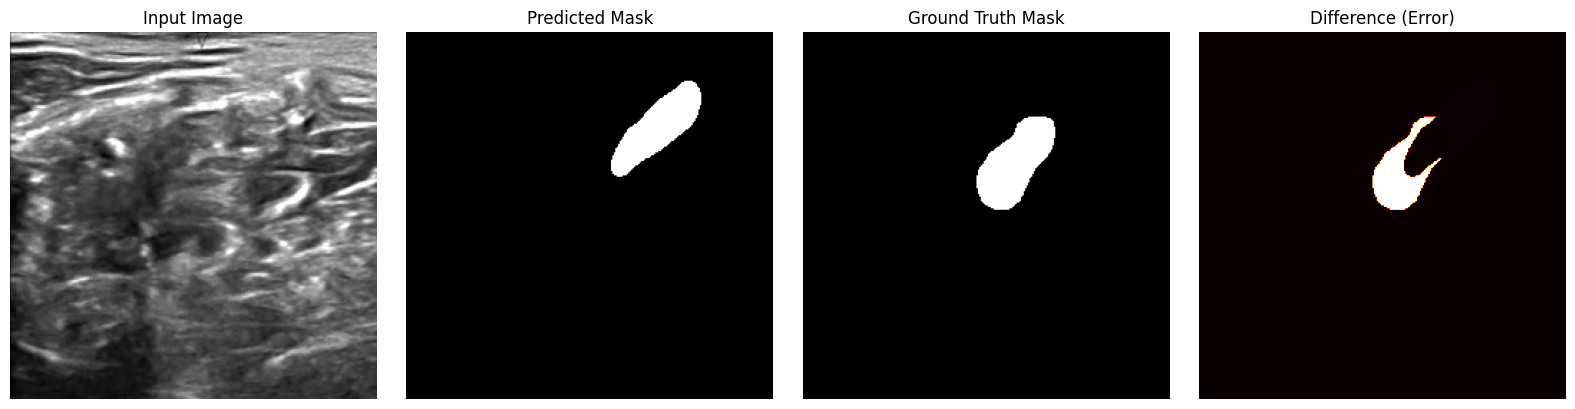

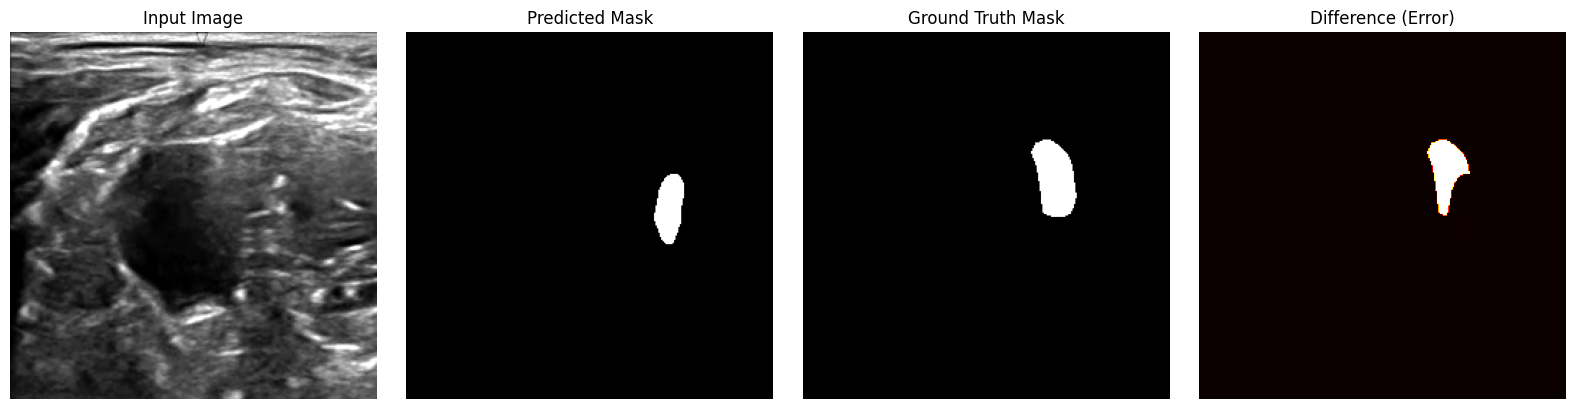

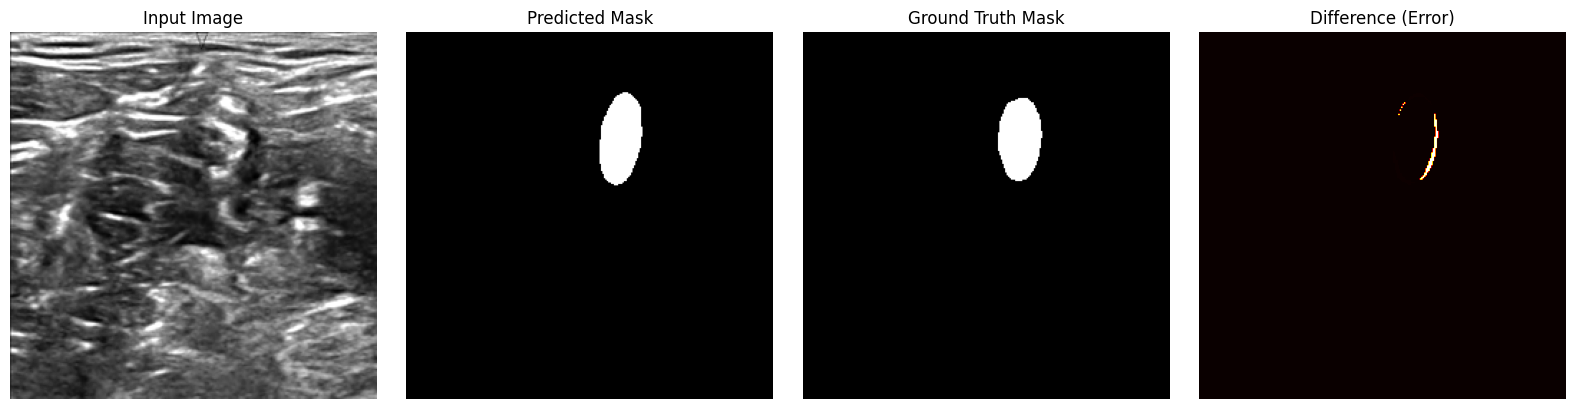

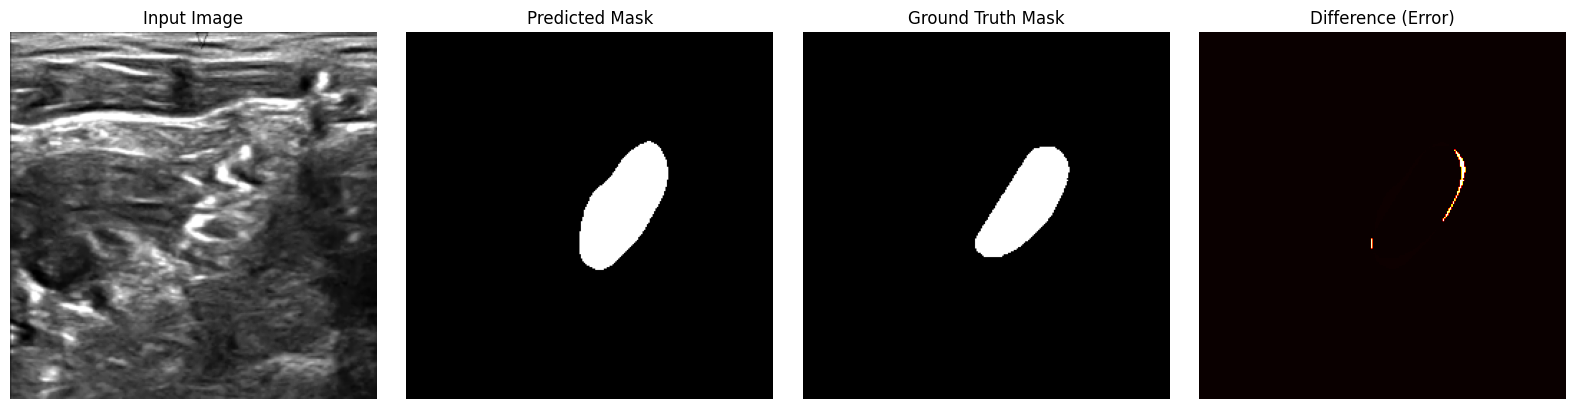

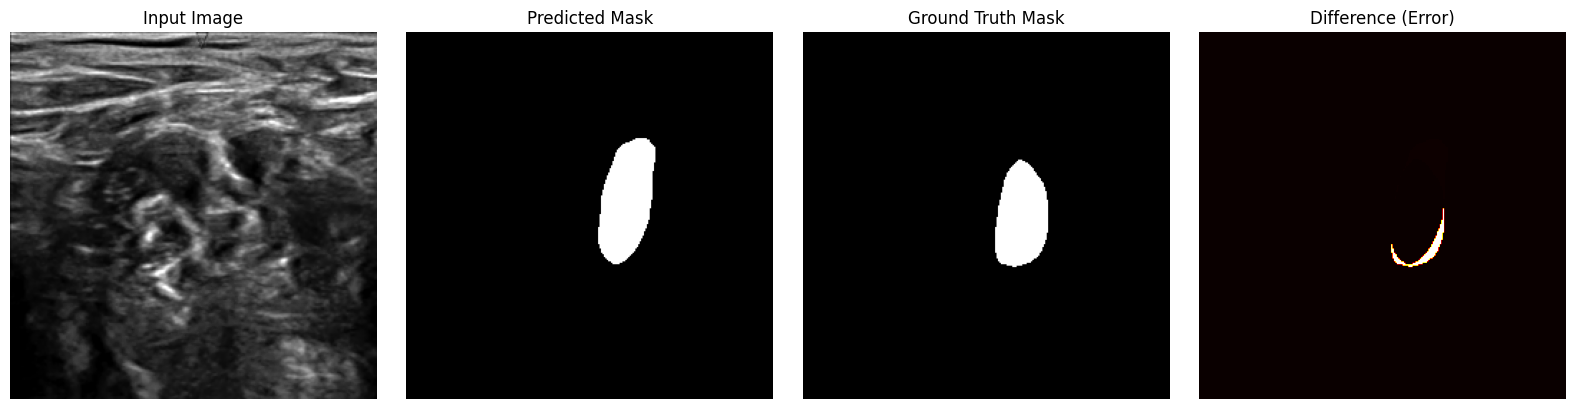

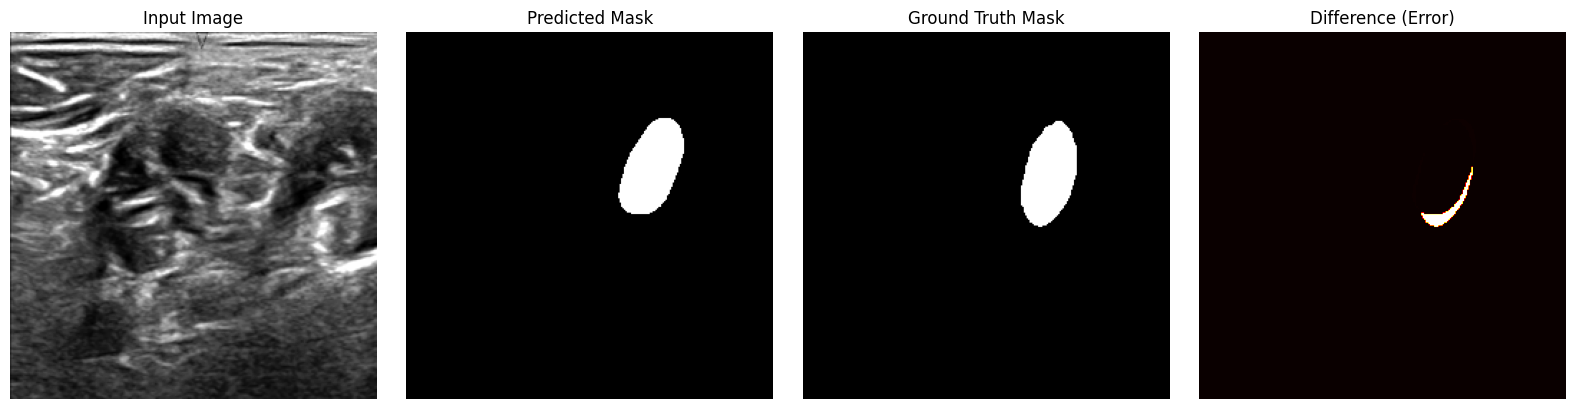

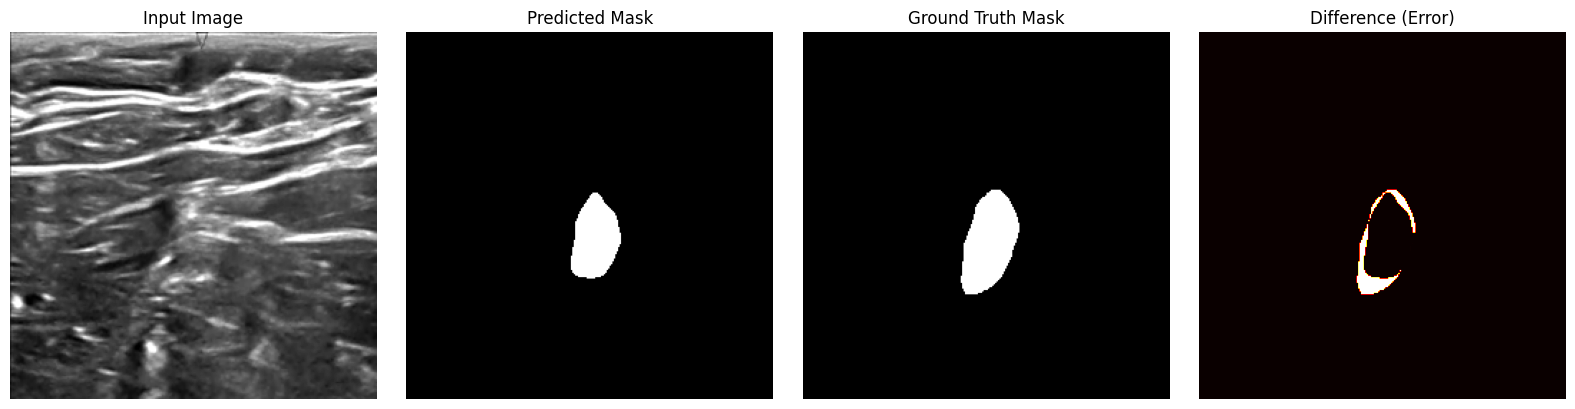

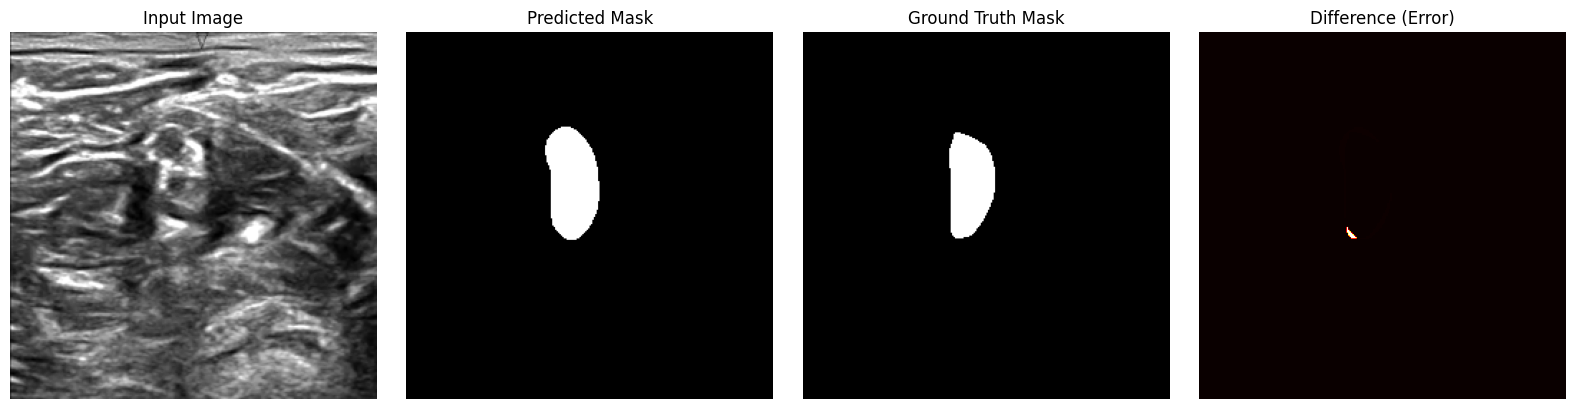

In [26]:
# --- Load model ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetResNet18().to(device)
model.load_state_dict(torch.load("best_model.pth", map_location=device))
model.eval()

def to_3channel(img_tensor):
    if img_tensor.shape[1] == 1:
        return img_tensor.repeat(1, 3, 1, 1)
    return img_tensor

# --- Get one batch from test_loader ---
images, masks = next(iter(test_loader))
images3 = to_3channel(images).to(device)
with torch.no_grad():
    outputs = model(images3)
    outputs = torch.sigmoid(outputs)
    preds = (outputs > 0.5).cpu().numpy().astype("uint8")

images_np = images.cpu().numpy()
masks_np = masks.cpu().numpy().astype("uint8")

# Plotting
batch_size = images.shape[0]
for i in range(batch_size):
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    # Input image
    axs[0].imshow(images_np[i, 0], cmap="gray")
    axs[0].set_title("Input Image")
    axs[0].axis("off")
    # Predicted mask
    axs[1].imshow(preds[i, 0], cmap="gray")
    axs[1].set_title("Predicted Mask")
    axs[1].axis("off")
    # Ground Truth
    axs[2].imshow(masks_np[i, 0], cmap="gray")
    axs[2].set_title("Ground Truth Mask")
    axs[2].axis("off")
    # Difference (highlight error pixels)
    diff = np.abs(preds[i, 0] - masks_np[i, 0])
    axs[3].imshow(diff, cmap="hot")
    axs[3].set_title("Difference (Error)")
    axs[3].axis("off")
    plt.tight_layout()
    plt.show()